In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [5]:
import numba as nb

@nb.njit
def gen_mc_acf(tau,nsteps,tmatrix,mu,var,ppi):
	## Using a transition probability matrix, not a rate matrix, or Q matrix
	## because this comes straight out of an HMM.... so not quick exact

	nstates,_ = tmatrix.shape
	pi0 = np.eye(nstates)

	## get steady state probabilities
	pinf = np.linalg.matrix_power(tmatrix.T,100*int(1./tmatrix.min()))[:,0]

	## use fluctuations
	mubar =  (pinf*mu).sum()
	mm = mu - mubar

	### expectation here
	E_y0yt = np.zeros(nsteps)
	for i in range(nstates): # loop over initial state
		for j in range(nstates): # loop over final state
			for k in range(nsteps): # loop over time delay steps
				## E[y_0*t_t] = \sum_ij m_i * m_j * (A^n \cdot \delta (P_i))_j * P_inf,i
				E_y0yt[k] += mm[i]*mm[j] * (np.dot(np.linalg.matrix_power(tmatrix.T,k),pi0[i])[j]) * pinf[i]

	## add gaussian noise terms
	for i in range(nstates):
		E_y0yt[0] += var[i]*pinf[i]
	## normalize
	E_y0yt /= E_y0yt[0]

	t = tau*np.arange(nsteps)
	return t,E_y0yt

In [6]:
def return_params(dataset, snr,tsh=4):
    if dataset == 'reg':
        mu =  np.array([0.0, 1.])
        s =  np.array([1., 1.])/snr
        pi = np.array([0.6, 0.4])
        transition = np.array([
            [0.98, 0.02],
            [0.03, 0.97]])

        return mu, s, pi, transition
    
    elif dataset == 'dynamic2':
        mu =  np.array([0.0, 1., 0., 1.])
        s =  np.array([1., 1., 1., 1.])/snr
        pi = np.array([0.2, 0.4/3, 0.6, 0.4])
        pi /= pi.sum()
        
        t1 = np.array([            #slow 0-1
                [0.98, 0.02],
                [0.03, 0.97]])
        t2 = np.array([            #fast 0-1
                [0.94, 0.06],
                [0.09, 0.91]])
        t3 = np.array([            #slow-fast
                [1-0.0005*tsh/1., 0.0005*tsh/1.],
                [0.0005*tsh/1., 1-0.0005*tsh/1.]])

        transition = np.array([
            [t1[0][0]*t3[0][0], t1[0][1]*t3[0][0], t2[0][0]*t3[0][1], t2[0][1]*t3[0][1]],
            [t1[1][0]*t3[0][0], t1[1][1]*t3[0][0], t2[1][0]*t3[0][1], t2[1][1]*t3[0][1]],
            [t1[0][0]*t3[1][0], t1[0][1]*t3[1][0], t2[0][0]*t3[1][1], t2[0][1]*t3[1][1]],
            [t1[1][0]*t3[1][0], t1[1][1]*t3[1][0], t2[1][0]*t3[1][1], t2[1][1]*t3[1][1]]]) #replaced 3 with 1

        return mu, s, pi, transition
    
    elif dataset == 'static2':
        mu =  np.array([0.0, 1.])
        s =  np.array([1., 1.])/snr
        pi = np.array([0.6, 0.4])

        transition1 = np.array([
            [0.94, 0.06],
            [0.09, 0.91]])

        transition2 = np.array([
            [0.98, 0.02],
            [0.03, 0.97]])

        return mu, s, pi, transition1, transition2

In [7]:
def return_acf(dataset, t_max, snr, prop=None, tsh=4):
	if dataset in ['static2', 'static3']:
		if dataset == 'static2':
			mu, s, pi, transition1, transition2 = return_params(dataset,snr)
			t, acf1 = gen_mc_acf(1, t_max, transition1, mu, s**2, pi )
			t, acf2 = gen_mc_acf(1, t_max, transition2, mu, s**2, pi )
		else:
			mu1, s1, pi1, transition1, mu2, s2, pi2, transition2 = return_params(dataset,snr)
			t, acf1 = gen_mc_acf(1, t_max, transition1, mu1, s1**2, pi1 )
			t, acf2 = gen_mc_acf(1, t_max, transition2, mu2, s2**2, pi2 )

		acf = (prop[0]*acf1 + prop[1]*acf2)/prop.sum()

	else:
		mu, s, pi, transition = return_params(dataset,snr,tsh)

		t, acf = gen_mc_acf(1, t_max, transition, mu, s**2, pi )

	return t, acf

In [8]:
t_r, acf_r = return_acf('reg', 1000, 9.0, prop=None)
t_d2, acf_d2 = return_acf('dynamic2', 1000, 9.0, prop=None)
t_s2, acf_s2 = return_acf('static2', 1000, 9.0, prop=np.array([0.25,0.75]))

C:\Users\Owner\AppData\Local\Temp\ipykernel_25092\2760219520.py:12: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  pinf = np.linalg.matrix_power(tmatrix.T,100*int(1./tmatrix.min()))[:,0]
C:\Users\Owner\AppData\Local\Temp\ipykernel_25092\2760219520.py:12: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  pinf = np.linalg.matrix_power(tmatrix.T,100*int(1./tmatrix.min()))[:,0]
C:\Users\Owner\AppData\Local\Temp\ipykernel_25092\2760219520.py:24: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  E_y0yt[k] += mm[i]*mm[j] * (np.dot(np.linalg.matrix_power(tmatrix.T,k),pi0[i])[j]) * pinf[i]


In [9]:
def compare_acf(t, truth, Es, cmap, xlim = 650, save_name = None, figs = None, keys=[0,0], hier=False):
    if figs is None:
        f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})
    else:
        f, (ax, ax2) = figs
    ax.set_xlim(-0., 1e-256)
    ax2.set_xlim(1, xlim)
    
    for j in keys:
        ax.plot(t,truth[float(int(j*100))/100],color=cmap(j*2),alpha=0.5,ls='--')
        ax2.plot(t,truth[float(int(j*100))/100],color=cmap(j*2),alpha=0.5,ls='--')
        
        if hier==True:
            ax.plot(t,np.nanmean(Es[int((j*100)/5)], axis=0),color=cmap(j*2))
            ax2.plot(t,np.nanmean(Es[int((j*100)/5)], axis=0),color=cmap(j*2),
                     label="{:.2f}".format(float(int(j*100))/100))
        else:
            ax.plot(t,np.nanmean(Es[j], axis=0),color=cmap(j*2))
            ax2.plot(t,np.nanmean(Es[j], axis=0),color=cmap(j*2),label="{:.2f}".format(float(int(j*100))/100))
        
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(right = False, left=False) 

    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax2.legend(fontsize=8)
    ax.set_ylabel('Normalised ACF')
    ax2.set_xlabel('Lag Time')
    if not save_name is None:
        plt.savefig(save_name)
    
    return f, (ax, ax2)

In [10]:
def lin_diff_model_acf(t, ref, acfs, cmap, tls, label=None,xlim=650, ylim=None, save_name = None, 
                       figs = None,keys=[0,0],hier=False):
    if figs is None:
        f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,3),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})
    else:
        f, (ax, ax2) = figs
    ax.set_xlim(-0., 1e-256)
    ax2.set_xlim(1, xlim)
    if ylim is not None:
        ax2.set_ylim(ylim[0], ylim[1])
        
    if hier==True:
        for j in keys:
            residual_Es = -ref[float(int(j*100))/100] + np.array(acfs[int((j*100)/5)])
            x = np.unique(np.where(np.isfinite(residual_Es[:,1]))[0])
            mean_Es = np.nanmean(residual_Es[x], axis = 0)
            percentile_975 = np.nanpercentile(residual_Es[x], 97.5, axis = 0)
            percentile_025 = np.nanpercentile(residual_Es[x], 2.5, axis = 0)

            ax.plot(t_r, mean_Es, color = cmap(j*2), ls = tls)
            ax2.plot(t_r, mean_Es, color = cmap(j*2), ls = tls, label = "{:.2f}".format(float(int(j*100))/100))
            ax.fill_between(t_r, percentile_975, percentile_025, color = cmap(j*2), 
                             edgecolor=cmap(j*2), ls = tls, alpha=0.25)
            ax2.fill_between(t_r, percentile_975, percentile_025, color = cmap(j*2), 
                             edgecolor=cmap(j*2), ls = tls, alpha=0.25)
    
    else: 
        for j in keys:
            residual_Es = -ref[float(int(j*100))/100] + np.array(acfs[j])
            x = np.unique(np.where(np.isfinite(residual_Es[:,1]))[0])
            mean_Es = np.nanmean(residual_Es[x], axis = 0)
            percentile_975 = np.nanpercentile(residual_Es[x], 97.5, axis = 0)
            percentile_025 = np.nanpercentile(residual_Es[x], 2.5, axis = 0)

            ax.plot(t_r, mean_Es, color = cmap(j*2), ls = tls)
            ax2.plot(t_r, mean_Es, color = cmap(j*2), ls = tls, label = "{:.2f}".format(float(int(j*100))/100))
            ax.fill_between(t_r, percentile_975, percentile_025, color = cmap(j*2), 
                             edgecolor=cmap(j*2), ls = tls, alpha=0.25)
            ax2.fill_between(t_r, percentile_975, percentile_025, color = cmap(j*2), 
                             edgecolor=cmap(j*2), ls = tls, alpha=0.25)
    
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(right = False, left=False) 

    ax.set_xscale('log')
    ax2.set_xscale('log')

    ax.set_ylabel('Residual')
    ax2.set_xlabel('Lag Time')
    if not save_name is None:
        plt.savefig(save_name)
    
    return f, (ax, ax2)

In [11]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(74/256 + (189-74)/10/256, 189/256,  N)
vals[:, 1] = np.linspace(98/256 + (98-65)/10/256, 65/256, N)
vals[:, 2] = np.linspace(189/256 + (65-189)/10/256, 65/256,  N)
vals[:, 3] *= 0.75
newcmp = ListedColormap(vals)

In [12]:
acf_ss = {}
for j in range(20):
    prop1 = j/20
    t, acf = return_acf('static2', 1000, 9.0, prop=np.array([prop1,1-prop1]))
    acf_ss[prop1] = acf

Text(0.5, 1.0, 'Global 2-State')

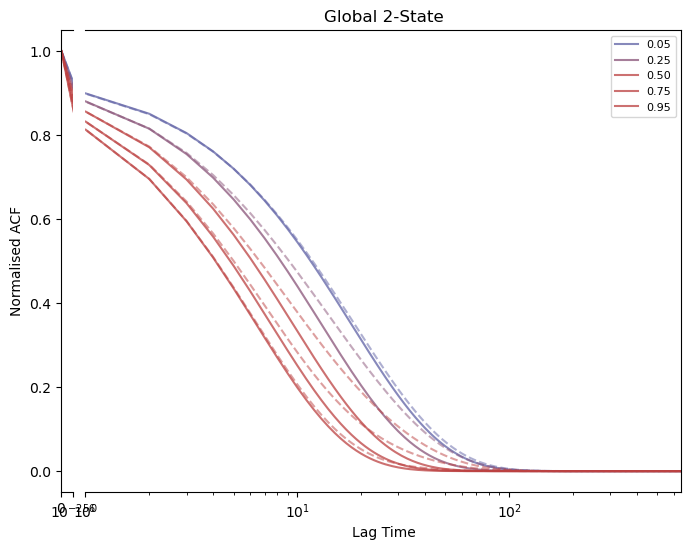

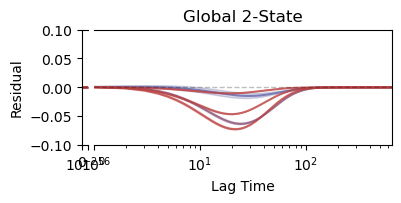

In [13]:
Edict_con2_s29_prop = pickle.load(open( "results/ACFdicts_2_hetstat_9.0_global_changeprop.p", "rb" ))

f, (ax, ax2) = plt.subplots(1, 2, figsize=(8,6),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
compare_acf(t_r, acf_ss, Edict_con2_s29_prop, newcmp, figs=(f, (ax, ax2)), keys=key_arr)
plt.title('Global 2-State')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
lin_diff_model_acf(t_r, acf_ss, Edict_con2_s29_prop, newcmp, '-', figs=(f, (ax, ax2)), keys=key_arr)
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.set_ylim(-0.1,0.1)
ax2.set_title('Global 2-State')

Text(0.5, 1.0, 'Global 4-State')

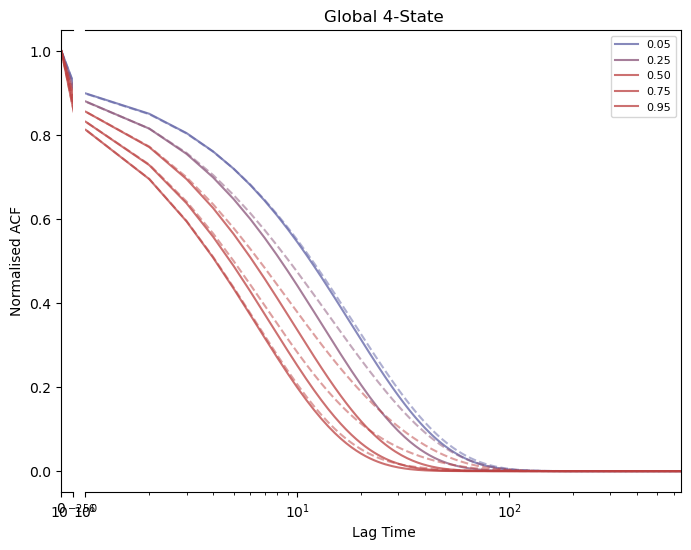

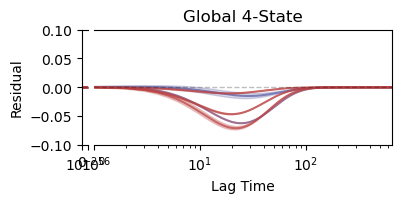

In [15]:
Edict_con4_s29_prop = pickle.load(open( "results/ACFdicts_4_hetstat_9.0_global_changeprop.p", "rb" ))

f, (ax, ax2) = plt.subplots(1, 2, figsize=(8,6),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
compare_acf(t_r, acf_ss, Edict_con4_s29_prop, newcmp, figs=(f, (ax, ax2)), keys=key_arr)
plt.title('Global 4-State')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
lin_diff_model_acf(t_r, acf_ss, Edict_con4_s29_prop, newcmp, '-', figs=(f, (ax, ax2)), keys=key_arr)

ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.set_ylim(-0.1,0.1)
ax2.set_title('Global 4-State')

Text(0.5, 1.0, 'Composite 2-State')

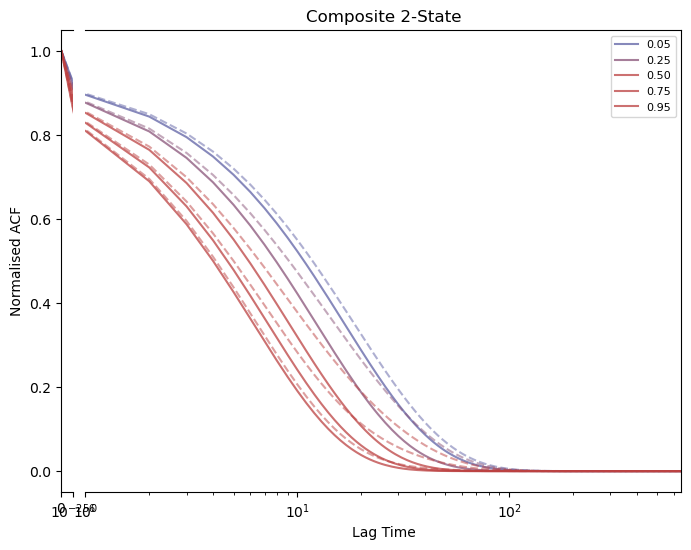

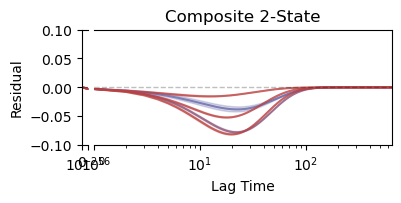

In [14]:
Edict_vb2_s29_prop = pickle.load(open( "results/ACFdicts_2_hetstat_9.0_composite_changeprop.p", "rb" ))

f, (ax, ax2) = plt.subplots(1, 2, figsize=(8,6),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
compare_acf(t_r, acf_ss, Edict_vb2_s29_prop, newcmp, figs=(f, (ax, ax2)), keys=key_arr)
plt.title('Composite 2-State')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
lin_diff_model_acf(t_r, acf_ss, Edict_vb2_s29_prop, newcmp, '-', figs=(f, (ax, ax2)), keys=key_arr)
    
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.set_ylim(-0.1,0.1)
ax2.set_title('Composite 2-State')

Text(0.5, 1.0, 'Composite 4-State')

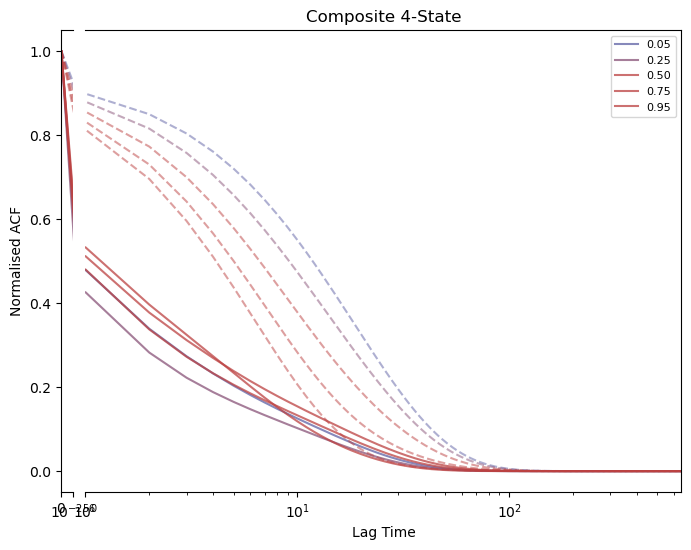

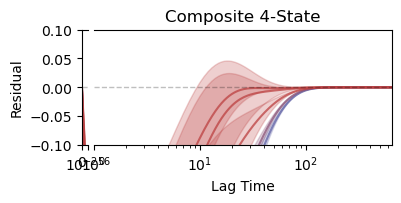

In [16]:
Edict_vb4_s29_prop = pickle.load(open( "results/ACFdicts_4_hetstat_9.0_composite_changeprop.p", "rb" ))

f, (ax, ax2) = plt.subplots(1, 2, figsize=(8,6),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
compare_acf(t_r, acf_ss, Edict_vb4_s29_prop, newcmp, figs=(f, (ax, ax2)), keys=key_arr)
plt.title('Composite 4-State')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
lin_diff_model_acf(t_r, acf_ss, Edict_vb4_s29_prop, newcmp, '-', figs=(f, (ax, ax2)), keys=key_arr)
    
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.25)
ax2.set_ylim(-0.1,0.1)
ax2.set_title('Composite 4-State')

In [18]:
Es_h_s2 = pickle.load(open( "results/ACFdicts_2_hetstat_9.0_hhmm_changeprop.p", "rb" ))

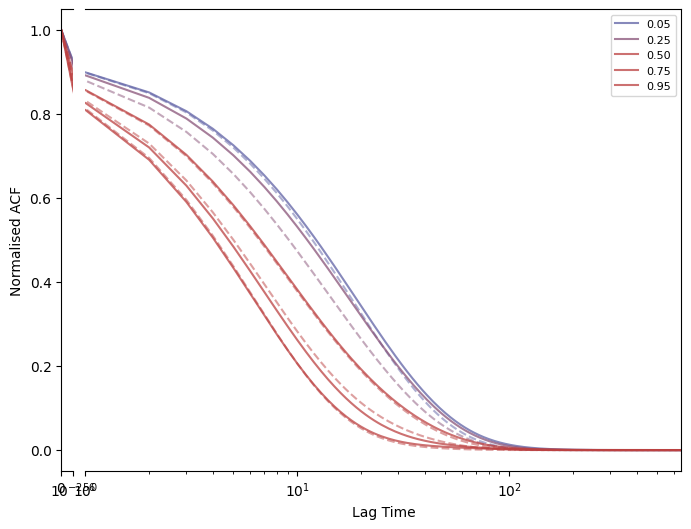

In [19]:
f, (ax, ax2) = plt.subplots(1, 2, figsize=(8,6),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
compare_acf(t_r, acf_ss, Es_h_s2, newcmp, figs=(f, (ax, ax2)), keys=key_arr)
plt.title('Hierarchical 4-State')

f, (ax, ax2) = plt.subplots(1, 2, figsize=(4,1.5),
                            sharey=True, gridspec_kw={'width_ratios': [1, 50],  'wspace':0.04})

key_arr = [0.05,0.25,0.5,0.75,0.9500000000000001]
lin_diff_model_acf(t_r, acf_ss, Es_h_s2, newcmp, '-', figs=(f, (ax, ax2)), keys=key_arr)
    
ax.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.15)
ax2.axhline(y = 0.00, ls = '--',color ='k',lw=1,alpha = 0.15)
ax2.set_ylim(-0.1,0.1)
plt.title('Hierarchical 4-State')